``Mission : Error Analysis & Model metadata``


# Data and dependencies

In [205]:
import warnings
import sys
import os
import time
import joblib
import random
from tqdm import tqdm
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from geopy.distance import geodesic

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import train_test_split, StratifiedKFold, TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder

from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

warnings.filterwarnings('ignore')

In [134]:
metadata = pd.read_csv('../data/metadata.csv')
sub_format = pd.read_csv('../data/submission_format.csv')
train_labels = pd.read_csv('../data/train_labels.csv')

In [135]:
def rmse(y_true, y_pred):
    return mse(y_true, y_pred, squared=False)

In [136]:
def dens_to_sev(x: float)-> int:
    """takes in density value in cells/ml and returns severity category"""
    if (x < 20_000) : return 1
    elif (x >= 20_000) and (x < 100_000) : return 2
    elif (x >= 100_000) and (x < 1_000_000) : return 3
    elif (x >= 1_000_000) and (x < 10_000_000) : return 4
    elif x > 10_000_000 : return 5

## Add date fts

In [137]:
metadata.date = pd.to_datetime(metadata.date)
metadata['year'] = metadata.date.dt.year
metadata['month'] = metadata.date.dt.month
metadata['week'] = metadata.date.dt.isocalendar().week


seasons = {
    1: 1,
    2: 1,
    3: 2,
    4: 2,
    5: 2,
    6: 3,
    7: 3,
    8: 3,
    9: 4,
    10: 4,
    11: 4,
    12: 1
}

metadata['season'] = metadata.month.map(seasons)


region = pd.concat((train_labels, sub_format[['region', 'uid']]), axis=0)

data = pd.merge(metadata, region, on='uid', how='left')
data

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density
0,aabm,39.080319,-86.430867,2018-05-14,train,2018,5,20,2,midwest,1.0,585.0
1,aabn,36.559700,-121.510000,2016-08-31,test,2016,8,35,3,west,NaN,NaN
2,aacd,35.875083,-78.878434,2020-11-19,train,2020,11,47,4,south,1.0,290.0
3,aaee,35.487000,-79.062133,2016-08-24,train,2016,8,34,3,south,1.0,1614.0
4,aaff,38.049471,-99.827001,2019-07-23,train,2019,7,30,3,midwest,3.0,111825.0
...,...,...,...,...,...,...,...,...,...,...,...,...
23565,zzvv,36.708500,-121.749000,2014-12-02,test,2014,12,49,1,west,NaN,NaN
23566,zzwo,39.792190,-99.971050,2017-06-19,train,2017,6,25,3,midwest,2.0,48510.0
23567,zzwq,35.794000,-79.012551,2015-03-24,train,2015,3,13,2,south,1.0,1271.0
23568,zzyb,35.742000,-79.238600,2016-11-21,train,2016,11,47,4,south,1.0,9682.0


In [138]:
test_data = data[data.split == 'test']
test_data.shape, data.shape

((6510, 12), (23570, 12))

In [139]:
train_data = data[data.split == 'train']
train_data.shape, data.shape

((17060, 12), (23570, 12))

# Utils

In [140]:
#  Utils
def get_data_by_date( date=None, data=train_data):
    return data[data.date == date]


def get_distance(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).km

def analyize_matches(y_true, y_pred):
    print("Exact matches: ", sum(y_true == y_pred) / len(y_true))
    
    print("Missed by 1: ", sum(abs(y_true - y_pred) == 1) / len(y_true))
    print("Missed by 2: ", sum(abs(y_true - y_pred) == 2) / len(y_true))
    print("Missed by 3: ", sum(abs(y_true - y_pred) == 3) / len(y_true))
    print("Missed by 4: ", sum(abs(y_true - y_pred) == 4) / len(y_true))

# My Guess

In [141]:
te_data = test_data.sort_values(by='date')
te_data

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density
6865,howw,37.0062,-120.600,2013-01-08,test,2013,1,2,1,west,NaN,NaN
3661,eamn,36.9818,-120.221,2013-01-08,test,2013,1,2,1,west,NaN,NaN
7668,imsv,36.9836,-120.500,2013-01-08,test,2013,1,2,1,west,NaN,NaN
20182,wgxq,33.8011,-117.205,2013-01-25,test,2013,1,4,1,west,NaN,NaN
16095,rsos,33.8892,-117.562,2013-01-25,test,2013,1,4,1,west,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
12443,nsoi,36.7368,-121.734,2021-12-29,test,2021,12,52,1,west,NaN,NaN
14254,prfi,36.7518,-121.742,2021-12-29,test,2021,12,52,1,west,NaN,NaN
6864,howu,36.7085,-121.749,2021-12-29,test,2021,12,52,1,west,NaN,NaN
6540,hfvr,36.7962,-121.782,2021-12-29,test,2021,12,52,1,west,NaN,NaN


## Train test split

In [142]:
tr_data, val_data = train_test_split(train_data, test_size=0.15, random_state=123456789, shuffle=True)
tr_data.shape, val_data.shape

((14501, 12), (2559, 12))

In [143]:
tr_data2, val_data2 = train_test_split(train_data, test_size=0.15, random_state=123456789, shuffle=True)
tr_data2.shape, val_data2.shape

((14501, 12), (2559, 12))

## Guess Funcs

In [144]:
fill_2s = []
g_from_past = {}

n_times_called = {}

def make_guess1(row: pd.Series, date=None, tr_data=tr_data) -> pd.Series:

    dists = []
    region = row.region
    date = date
    uid = row.uid
    tr_data = tr_data

    if date is None:
        date = row.date

    rel_data = tr_data[(tr_data.date == date) & (tr_data.region == region)]
    
    # check if cur date is past '2013-01-04'
    if date < pd.to_datetime('2013-01-04'):
        print(f'No previous data for this date filling in 2s .. for {row.uid}')
        fill_2s.append(uid)
        return 2

    if rel_data.shape[0] == 0:
        # print(f'No data for this date, trying previous day.. for {row.uid}')
        if g_from_past.get(uid) is not None:
            g_from_past[uid] += 1
        return make_guess1(row, date=date - pd.Timedelta(days=1), tr_data=tr_data)

    for some_row in rel_data.itertuples():
        dist = get_distance(row.latitude, row.longitude, some_row.latitude, some_row.longitude)
        dists.append(dist)
    
    nearest = rel_data.iloc[np.argmin(dists)]
    return nearest.severity


def make_guess2(row: pd.Series, date=None, tr_data=tr_data, n_times_called=None) -> pd.Series:
    """modified version of make_guess1, Uses mean/mode of severity for the region instead of nearest severity."""
    dists = []
    region = row.region
    date = date
    uid = row.uid
    tr_data = tr_data
    
    if n_times_called is not None:
        if n_times_called.get(uid) is None:
            n_times_called[uid] = 1
        else:
            n_times_called[uid] += 1
        

    if date is None:
        date = row.date

    rel_data = tr_data[(tr_data.date == date) & (tr_data.region == region)]
    
    # check if cur date is past '2013-01-04'
    if date < pd.to_datetime('2013-01-04'):
        print(f'No previous data for this date filling in 2s .. for {row.uid}')
        fill_2s.append(uid)
        return 2

    if rel_data.shape[0] == 0:
        # print(f'No data for this date, trying previous day.. for {row.uid}')
        if g_from_past.get(uid) is not None:
            g_from_past[uid] += 1
        global count 
        count += 1
        return make_guess2(row, date=date - pd.Timedelta(days=1), tr_data=tr_data)

    severty_mode = rel_data.severity.mode()[0]
    severty_mean = np.round(rel_data.severity.mean())

    return severty_mean



def cv_loop(rand, splits=10, guess_func=make_guess1):
    # print("Random Number: ", rand)
    skf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=rand)
    tscv = TimeSeriesSplit(n_splits=splits)
    
    rmses = []
    guess_train_preds = np.zeros((train_data.shape[0]))

    for fold, (train_idx, val_idx) in enumerate(tscv.split(train_data, train_data.severity)):
        print(f"Fold: {fold}")
        tr_data, val_data = train_data.iloc[train_idx], train_data.iloc[val_idx]

        val_data['guess'] = 0

        temp = []
        for row in tqdm(val_data.itertuples(), total=val_data.shape[0]):
            uid_series = val_data[val_data.uid == row.uid]
            severity = guess_func(uid_series.iloc[0], date=row.date, tr_data=tr_data)
            val_data.loc[val_data.uid == row.uid, f'guess'] = severity
            temp.append(severity)
        
        guess_train_preds[val_idx] = temp
        

                
        errror = rmse(val_data.severity, val_data.guess1)
        rmses.append(errror)
        print("RMSE: ", errror)

        print('Train Distribution: ')
        print(tr_data.severity.value_counts(normalize=True))
        print('Val Distribution: ')
        print(val_data.severity.value_counts(normalize=True))
        print('Predicted Distribution: ')
        print(val_data.guess1.value_counts(normalize=True))

    
    print('----------------------------------------------------')

    return rmses, guess_train_preds


In [145]:
tr_data.sort_values(by='date', inplace=True)
val_data.sort_values(by='date', inplace=True)

In [146]:
tr_data2.sort_values(by='date', inplace=True)
val_data2.sort_values(by='date', inplace=True)

### Failed way of validation

In [147]:
for row in tqdm(val_data.itertuples(), total=val_data.shape[0]):
    val_data.loc[row.Index, 'guess'] = make_guess1(row)

analyize_matches(val_data.severity, val_data.guess)
rmse(val_data.severity, val_data.guess)

 15%|█▍        | 378/2559 [00:03<00:22, 95.32it/s] 


KeyboardInterrupt: 

In [ ]:
# 0.08284486127393513 + 0.008206330597889801 + 0.0011723329425556857
# 91% preds < 1 offs, 99% preds < 2 offs, 88% preds == 2 offs

In [ ]:
count = 0

for row in tqdm(val_data.itertuples(), total=val_data.shape[0]):
    val_data.loc[row.Index, 'guess'] = make_guess2(row)

analyize_matches(val_data.severity, val_data.guess)

rmse(val_data.severity, val_data.guess)

100%|██████████| 2559/2559 [00:07<00:00, 333.95it/s]

Exact matches:  0.5560765924189136
Missed by 1:  0.3903868698710434
Missed by 2:  0.047284095349745994
Missed by 3:  0.005861664712778429
Missed by 4:  0.00039077764751856197


0.7990811448440829

### New Era VAL SET

In [ ]:
val_data2['date_reg'] = val_data2.date.astype(str) + "_" +  val_data2.region
tr_data2['date_reg'] = tr_data2.date.astype(str) + "_" +  tr_data2.region

assert (val_data2.columns == tr_data2.columns).all()

print(set(val_data2.uid).intersection(set(tr_data2.uid)))

#  Intersection percentage of date and regs before
print(len(set(val_data2.date_reg).intersection(set(tr_data2.date_reg)))/val_data2.date_reg.nunique())

set()
0.9328793774319066


In [ ]:
datereg_to_remove = val_data2.date_reg.sample(frac=0.40, random_state=123456789)
tr_data2_ = tr_data2[~tr_data2.date_reg.isin(datereg_to_remove)]

len(set(val_data2.date_reg).intersection(set(tr_data2_.date_reg)))/val_data2.date_reg.nunique()

0.372568093385214

In [ ]:
len(set(val_data2.date).intersection(set(tr_data2_.date)))/val_data2.date.nunique()

0.6537013801756587

In [ ]:
len(set(test_data.date).intersection(set(train_data.date)))/test_data.date.nunique()

0.701095461658842

In [ ]:
tr_data2_.shape, val_data2.shape, train_data.shape, val_data.shape

((5712, 13), (2559, 13), (17060, 12), (2559, 12))

In [ ]:
tr_data3 = tr_data2.copy()
val_data3 = val_data2.copy()

datereg_to_remove = tr_data3.date_reg.sample(frac=0.60, random_state=123456789)
val_data3_ = val_data3[~val_data3.date_reg.isin(datereg_to_remove)]

len(set(val_data3_.date_reg).intersection(set(tr_data3.date_reg)))/val_data3_.date_reg.nunique()

0.43902439024390244

In [ ]:
len(set(val_data3_.date).intersection(set(tr_data2_.date)))/val_data3_.date.nunique()

0.6186440677966102

In [ ]:
val_data3.shape, val_data3_.shape, tr_data3.shape

#  I wonder if this is a good idea!

((2559, 13), (137, 13), (14501, 13))

In [ ]:
# for row in tqdm(val_data3_.itertuples(), total=val_data3_.shape[0]):
#     val_data3_.loc[row.Index, 'guess'] = make_guess2(row, tr_data=tr_data3)

# analyize_matches(val_data3_.severity, val_data3_.guess)

# rmse(val_data3_.severity, val_data3_.guess)

100%|██████████| 137/137 [00:01<00:00, 89.73it/s] 

Exact matches:  0.5182481751824818
Missed by 1:  0.29927007299270075
Missed by 2:  0.145985401459854
Missed by 3:  0.0364963503649635
Missed by 4:  0.0


1.100762840995638

### Eval

In [ ]:
def eval( guess_func=make_guess2, val_data=val_data3_, tr_data=tr_data3):
    for row in tqdm(val_data.itertuples(), total=val_data.shape[0]):
        val_data.loc[row.Index, 'guess'] = guess_func(row, tr_data=tr_data)
    analyize_matches(val_data.severity, val_data.guess)
    return rmse(val_data.severity, val_data.guess)

In [ ]:
eval()

100%|██████████| 137/137 [00:01<00:00, 88.98it/s] 

Exact matches:  0.5182481751824818
Missed by 1:  0.29927007299270075
Missed by 2:  0.145985401459854
Missed by 3:  0.0364963503649635
Missed by 4:  0.0


1.100762840995638

In [ ]:
eval(val_data=val_data3, tr_data=tr_data3)

100%|██████████| 2559/2559 [00:08<00:00, 301.92it/s]

Exact matches:  0.5560765924189136
Missed by 1:  0.3903868698710434
Missed by 2:  0.047284095349745994
Missed by 3:  0.005861664712778429
Missed by 4:  0.00039077764751856197


0.7990811448440829

In [ ]:
eval(val_data=val_data2, tr_data=tr_data2_)

  0%|          | 6/2559 [00:00<00:49, 51.36it/s]

No previous data for this date filling in 2s .. for pfly
No previous data for this date filling in 2s .. for jalu
No previous data for this date filling in 2s .. for jubi
No previous data for this date filling in 2s .. for pdqu
No previous data for this date filling in 2s .. for ipsj


  0%|          | 12/2559 [00:00<01:04, 39.63it/s]

No previous data for this date filling in 2s .. for acmt
No previous data for this date filling in 2s .. for htnz
No previous data for this date filling in 2s .. for kptf


100%|██████████| 2559/2559 [00:29<00:00, 88.17it/s] 

Exact matches:  0.5166080500195389
Missed by 1:  0.3583431027745213
Missed by 2:  0.08909730363423213
Missed by 3:  0.03477921062915201
Missed by 4:  0.0011723329425556857


1.0229870673936738

In [ ]:
train_data[train_data.uid == 'kptf']

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density
9649,kptf,38.307,-121.794,2013-02-19,train,2013,2,8,1,west,4.0,6930000.0


In [ ]:
tr_data3

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density,date_reg
13644,paev,44.822478,-93.367962,2013-01-04,train,2013,1,1,1,midwest,1.0,1884.0,2013-01-04_midwest
4387,evep,44.847993,-93.476318,2013-01-04,train,2013,1,1,1,midwest,1.0,115.0,2013-01-04_midwest
5566,gdxr,44.877646,-93.557842,2013-01-04,train,2013,1,1,1,midwest,1.0,1416.0,2013-01-04_midwest
6144,guny,44.878889,-93.490833,2013-01-04,train,2013,1,1,1,midwest,1.0,558.0,2013-01-04_midwest
5317,fwbt,44.850500,-93.515700,2013-01-04,train,2013,1,1,1,midwest,1.0,476.0,2013-01-04_midwest
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23159,zoaj,36.060000,-78.760000,2021-12-14,train,2021,12,50,1,south,2.0,48233.0,2021-12-14_south
18793,uscb,35.980000,-78.843636,2021-12-14,train,2021,12,50,1,south,2.0,20021.0,2021-12-14_south
12047,ngxt,35.980000,-78.844133,2021-12-14,train,2021,12,50,1,south,1.0,5187.0,2021-12-14_south
22641,yyvh,35.980000,-78.843138,2021-12-14,train,2021,12,50,1,south,1.0,1660.0,2021-12-14_south


In [ ]:
val_data3_.region.value_counts(normalize=True)

west         0.386861
northeast    0.291971
south        0.167883
midwest      0.153285
Name: region, dtype: float64

In [ ]:
test_data.region.value_counts(normalize=True)

west         0.366667
midwest      0.240399
south        0.232104
northeast    0.160829
Name: region, dtype: float64

In [ ]:
val_data2.region.value_counts(normalize=True)

south        0.582649
west         0.222352
midwest      0.132864
northeast    0.062134
Name: region, dtype: float64

In [ ]:
val_data2.severity.value_counts(normalize=True)

1.0    0.439234
4.0    0.205940
2.0    0.192263
3.0    0.158265
5.0    0.004299
Name: severity, dtype: float64

In [ ]:
val_data3_.severity.value_counts(normalize=True)

1.0    0.357664
4.0    0.270073
3.0    0.189781
2.0    0.167883
5.0    0.014599
Name: severity, dtype: float64

In [ ]:
val_data3_

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density,date_reg,guess
13772,pdqu,38.59010,-121.731000,2013-01-22,train,2013,1,4,1,west,4.0,4.180000e+06,2013-01-22_west,4.0
6595,hhfq,38.30560,-122.026000,2013-03-20,train,2013,3,12,2,west,4.0,7.220000e+06,2013-03-20_west,4.0
2087,cimy,33.19360,-104.356700,2013-03-20,train,2013,3,12,2,west,1.0,1.301653e+03,2013-03-20_west,4.0
11867,napd,38.59010,-121.731000,2013-03-20,train,2013,3,12,2,west,4.0,7.457500e+06,2013-03-20_west,4.0
23487,zxjy,32.38401,-104.145830,2013-06-06,train,2013,6,23,3,west,2.0,7.108144e+04,2013-06-06_west,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13421,otnr,41.56372,-75.707820,2021-07-26,train,2021,7,30,3,northeast,3.0,1.581330e+05,2021-07-26_northeast,3.0
15725,rhru,40.35642,-76.409560,2021-07-26,train,2021,7,30,3,northeast,1.0,1.600000e+03,2021-07-26_northeast,3.0
17089,sulb,41.50357,-111.022560,2021-07-27,train,2021,7,30,3,west,5.0,1.855960e+07,2021-07-27_west,4.0
14474,pxhr,35.68000,-79.109639,2021-08-14,train,2021,8,32,3,south,3.0,1.321570e+05,2021-08-14_south,3.0


In [ ]:
avg_sev_reg = tr_data3.groupby('region').severity.mean().apply(np.round)
avg_sev_reg

region
midwest      2.0
northeast    2.0
south        2.0
west         4.0
Name: severity, dtype: float64

In [ ]:
tr_data3

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density,date_reg
13644,paev,44.822478,-93.367962,2013-01-04,train,2013,1,1,1,midwest,1.0,1884.0,2013-01-04_midwest
4387,evep,44.847993,-93.476318,2013-01-04,train,2013,1,1,1,midwest,1.0,115.0,2013-01-04_midwest
5566,gdxr,44.877646,-93.557842,2013-01-04,train,2013,1,1,1,midwest,1.0,1416.0,2013-01-04_midwest
6144,guny,44.878889,-93.490833,2013-01-04,train,2013,1,1,1,midwest,1.0,558.0,2013-01-04_midwest
5317,fwbt,44.850500,-93.515700,2013-01-04,train,2013,1,1,1,midwest,1.0,476.0,2013-01-04_midwest
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23159,zoaj,36.060000,-78.760000,2021-12-14,train,2021,12,50,1,south,2.0,48233.0,2021-12-14_south
18793,uscb,35.980000,-78.843636,2021-12-14,train,2021,12,50,1,south,2.0,20021.0,2021-12-14_south
12047,ngxt,35.980000,-78.844133,2021-12-14,train,2021,12,50,1,south,1.0,5187.0,2021-12-14_south
22641,yyvh,35.980000,-78.843138,2021-12-14,train,2021,12,50,1,south,1.0,1660.0,2021-12-14_south


In [ ]:
def guess_avgsevreg(row, **kwargs):
    return avg_sev_reg[row.region]

In [ ]:
eval(guess_func=guess_avgsevreg)

100%|██████████| 137/137 [00:00<00:00, 5616.84it/s]

Exact matches:  0.31386861313868614
Missed by 1:  0.5036496350364964
Missed by 2:  0.12408759124087591
Missed by 3:  0.058394160583941604
Missed by 4:  0.0


1.2351305377390174

In [ ]:
#  Expanding severity man grop by region and season

data3 = pd.concat([tr_data3, val_data3_], axis=0)
data3.sort_values(by='date', inplace=True)

In [ ]:
val_data3_

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density,date_reg,guess
13772,pdqu,38.59010,-121.731000,2013-01-22,train,2013,1,4,1,west,4.0,4.180000e+06,2013-01-22_west,4.0
6595,hhfq,38.30560,-122.026000,2013-03-20,train,2013,3,12,2,west,4.0,7.220000e+06,2013-03-20_west,4.0
2087,cimy,33.19360,-104.356700,2013-03-20,train,2013,3,12,2,west,1.0,1.301653e+03,2013-03-20_west,4.0
11867,napd,38.59010,-121.731000,2013-03-20,train,2013,3,12,2,west,4.0,7.457500e+06,2013-03-20_west,4.0
23487,zxjy,32.38401,-104.145830,2013-06-06,train,2013,6,23,3,west,2.0,7.108144e+04,2013-06-06_west,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13421,otnr,41.56372,-75.707820,2021-07-26,train,2021,7,30,3,northeast,3.0,1.581330e+05,2021-07-26_northeast,2.0
15725,rhru,40.35642,-76.409560,2021-07-26,train,2021,7,30,3,northeast,1.0,1.600000e+03,2021-07-26_northeast,2.0
17089,sulb,41.50357,-111.022560,2021-07-27,train,2021,7,30,3,west,5.0,1.855960e+07,2021-07-27_west,4.0
14474,pxhr,35.68000,-79.109639,2021-08-14,train,2021,8,32,3,south,3.0,1.321570e+05,2021-08-14_south,2.0


In [ ]:
data3[data3.date == '2013-03-20']

,uid,latitude,longitude,date,split,year,month,week,season,region,severity,density,date_reg,guess
11867,napd,38.5901,-121.731000,2013-03-20,train,2013,3,12,2,west,4.0,7.457500e+06,2013-03-20_west,4.0
6595,hhfq,38.3056,-122.026000,2013-03-20,train,2013,3,12,2,west,4.0,7.220000e+06,2013-03-20_west,4.0
2012,cgdm,38.1205,-122.200000,2013-03-20,train,2013,3,12,2,west,4.0,5.795000e+06,2013-03-20_west,NaN
2087,cimy,33.1936,-104.356700,2013-03-20,train,2013,3,12,2,west,1.0,1.301653e+03,2013-03-20_west,4.0
1208,bjij,35.9760,-78.710406,2013-03-20,train,2013,3,12,2,south,1.0,2.905000e+03,2013-03-20_south,NaN
19544,vnkl,36.0280,-78.716000,2013-03-20,train,2013,3,12,2,south,2.0,5.962300e+04,2013-03-20_south,NaN
396,alxv,35.9760,-78.709661,2013-03-20,train,2013,3,12,2,south,1.0,1.742700e+04,2013-03-20_south,NaN
14448,pwpz,35.9760,-78.710158,2013-03-20,train,2013,3,12,2,south,1.0,1.022400e+04,2013-03-20_south,NaN
11641,mucf,35.9760,-78.709412,2013-03-20,train,2013,3,12,2,south,2.0,2.120300e+04,2013-03-20_south,NaN


In [ ]:
val_data3_.split = 'val'
tr_data3.split = 'train'

train_data3 = pd.concat([tr_data3, val_data3_], axis=0)
train_data3.sort_values(by='date', inplace=True)

train_data3.isna().sum()

uid              0
latitude         0
longitude        0
date             0
split            0
year             0
month            0
week             0
season           0
region           0
severity         0
density          0
date_reg         0
guess        14501
dtype: int64

In [ ]:
grp_by_rm = train_data3.groupby(['region', 'month']).severity.expanding(1).mean()
grp_by_rm = grp_by_rm.map(np.round)
print(grp_by_rm.isna().sum())  # 72 --> 0.8528

grp_by_rm.fillna(2, inplace=True)
analyize_matches(val_data3_.severity.sort_index(), grp_by_rm.droplevel(0).droplevel(0).loc[val_data3_.index].sort_index())
rmse(val_data3_.severity.sort_index(), grp_by_rm.droplevel(0).droplevel(0).loc[val_data3_.index].sort_index())

0
Exact matches:  0.4233576642335766
Missed by 1:  0.40875912408759124
Missed by 2:  0.12408759124087591
Missed by 3:  0.043795620437956206
Missed by 4:  0.0


1.1398552859870856

In [ ]:
tr_data2_.shape, val_data2.shape

((5712, 13), (2559, 14))

In [ ]:
train_data2 = pd.concat([tr_data2_, val_data2], axis=0)
train_data2.sort_values(by='date', inplace=True)
train_data2.loc[val_data2.index, 'severity'] = np.nan

train_data2.isna().sum()

uid             0
latitude        0
longitude       0
date            0
split           0
year            0
month           0
week            0
season          0
region          0
severity     2559
density         0
date_reg        0
guess        5712
dtype: int64

In [ ]:

grp_by_region = train_data2.groupby('region').severity.expanding(1).mean()
grp_by_region = grp_by_region.map(np.round)

grp_by_region['west'].fillna(2, inplace=True)
grp_by_region['northeast'].fillna(2, inplace=True)
print(grp_by_region.isna().sum())   # 5 --> 0.89416

rmse(val_data2.severity.sort_index(), grp_by_region.droplevel(0).loc[val_data2.index].sort_index())

0


0.9202256039541193

In [ ]:
grp_by_week = train_data2.groupby('week').severity.expanding(1).mean()
grp_by_week = grp_by_week.map(np.round)
print(grp_by_week.isna().sum())  # 105 --> 1.176284

grp_by_week.fillna(2, inplace=True)

analyize_matches(val_data2.severity.sort_index(), grp_by_week.droplevel(0).loc[val_data2.index].sort_index())
rmse(val_data2.severity.sort_index(), grp_by_week.droplevel(0).loc[val_data2.index].sort_index())

71
Exact matches:  0.21805392731535755
Missed by 1:  0.5138726064869089
Missed by 2:  0.22821414615084018
Missed by 3:  0.039077764751856196
Missed by 4:  0.0007815552950371239


1.338257807217118

In [ ]:

grp_by_season = train_data2.groupby('season').severity.expanding(1).mean()
grp_by_season = grp_by_season.map(np.round)
print(grp_by_season.isna().sum())  # 105 --> 1.176284
grp_by_season.fillna(2, inplace=True)

analyize_matches(val_data2.severity.sort_index(), grp_by_season.droplevel(0).loc[val_data2.index].sort_index())

rmse(val_data2.severity.sort_index(), grp_by_season.droplevel(0).loc[val_data2.index].sort_index())

7
Exact matches:  0.1930441578741696
Missed by 1:  0.5701445877295819
Missed by 2:  0.22665103556076593
Missed by 3:  0.01016021883548261
Missed by 4:  0.0


1.2522742109825584

In [ ]:
grp_by_month = train_data2.groupby('month').severity.expanding(1).mean()
grp_by_month = grp_by_month.map(np.round)
print(grp_by_month.isna().sum())  # 105 --> 1.176284

grp_by_month.fillna(2, inplace=True)

rmse(val_data2.severity.sort_index(), grp_by_month.droplevel(0).loc[val_data2.index].sort_index())

12


1.2648492751869658

In [ ]:
grp_by_yr = train_data2.groupby('year').severity.expanding(1).mean()
grp_by_yr = grp_by_yr.map(np.round)

print(grp_by_yr.isna().sum())   # 5 --> 0.89416
grp_by_yr.fillna(2, inplace=True)

rmse(val_data2.severity.sort_index(), grp_by_yr.droplevel(0).loc[val_data2.index].sort_index())

8


1.3596944695078805

In [ ]:
grp_by_date = train_data2.groupby('date').severity.expanding(1).mean()
grp_by_date = grp_by_date.map(np.round)

print(grp_by_date.isna().sum())   # 5 --> 0.89416
grp_by_date.fillna(2, inplace=True)

rmse(val_data2.severity.sort_index(), grp_by_date.droplevel(0).loc[val_data2.index].sort_index())

1489


1.3850369928881396

In [ ]:
grp_by_rm = train_data2.groupby(['region', 'month']).severity.expanding(1).mean()
grp_by_rm = grp_by_rm.map(np.round)
print(grp_by_rm.isna().sum())  # 72 --> 0.8528

grp_by_rm.fillna(2, inplace=True)

analyize_matches(val_data2.severity.sort_index(), grp_by_rm.droplevel(0).droplevel(0).loc[val_data2.index].sort_index())
rmse(val_data2.severity.sort_index(), grp_by_rm.droplevel(0).droplevel(0).loc[val_data2.index].sort_index())

55
Exact matches:  0.45603751465416176
Missed by 1:  0.4693239546697929
Missed by 2:  0.06486908948808129
Missed by 3:  0.009378663540445486
Missed by 4:  0.00039077764751856197


0.9052407010549318

In [ ]:

grp_by_rm = train_data2.groupby(['region', 'year']).severity.expanding(1).mean()
grp_by_rm = grp_by_rm.map(np.round)
print(grp_by_rm.isna().sum())  # 72 --> 0.8528

grp_by_rm.fillna(2, inplace=True)

analyize_matches(grp_by_rm.droplevel(0).droplevel(0).loc[val_data2.index].sort_index(), val_data2.severity.sort_index())
rmse(val_data2.severity.sort_index(), grp_by_rm.droplevel(0).droplevel(0).loc[val_data2.index].sort_index())

48
Exact matches:  0.5404454865181711
Missed by 1:  0.35873388042203985
Missed by 2:  0.08597108245408362
Missed by 3:  0.013677217663149667
Missed by 4:  0.0011723329425556857


0.9189507583584728

In [ ]:
grp_by_rm = train_data2.groupby(['region', 'season']).severity.expanding(1).mean()
grp_by_rm = grp_by_rm.map(np.round)
print(grp_by_rm.isna().sum())  # 72 --> 0.8528

grp_by_rm.fillna(2, inplace=True)

analyize_matches(grp_by_rm.droplevel(0).droplevel(0).loc[val_data2.index].sort_index(), val_data2.severity.sort_index())

rmse(val_data2.severity.sort_index(), grp_by_rm.droplevel(0).droplevel(0).loc[val_data2.index].sort_index())

30
Exact matches:  0.4404064087534193
Missed by 1:  0.4904259476357952
Missed by 2:  0.0605705353653771
Missed by 3:  0.007424775302852677
Missed by 4:  0.0011723329425556857


0.9045929437619269

In [ ]:
grp_by_rm = train_data2.groupby(['region', 'date']).severity.expanding(1).mean()
grp_by_rm = grp_by_rm.map(np.round)
print(grp_by_rm.isna().sum())  # 72 --> 0.8528

grp_by_rm.fillna(2, inplace=True)

preds = grp_by_rm.droplevel(0).droplevel(0).loc[val_data2.index].sort_index()
analyize_matches(val_data2.severity.sort_index(), preds)
rmse(val_data2.severity.sort_index(), preds)

2189
Exact matches:  0.252442360296991
Missed by 1:  0.567409144196952
Missed by 2:  0.17506838608831574
Missed by 3:  0.005080109417741305
Missed by 4:  0.0


1.1460382512420284

# MI scores

In [ ]:
from sklearn.feature_selection import mutual_info_classif

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features, random_state=1000, n_neighbors=5)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [ ]:
dummy_train_data = train_data.copy()
dummy_train_data['split'] = dummy_train_data['split'].map({'train': 0, 'val': 1})
dummy_train_data['region'] = dummy_train_data['region'].map({'midwest': 1, 'west': 2, 'south': 3, 'northeast': 4})
dummy_train_data.drop(['date', 'uid'], axis=1, inplace=True)
# dummy_train_data.drop('severity', axis=1, inplace=True)

In [ ]:
dummy_train_data.dtypes

latitude     float64
longitude    float64
split          int64
year           int64
month          int64
week          UInt32
season         int64
region         int64
severity     float64
density      float64
dtype: object

In [ ]:
#  find out mutual information between features and target
mi_scores = make_mi_scores(dummy_train_data, train_data.severity, discrete_features=True)
mi_scores

density      1.315350
severity     1.315350
longitude    1.067910
latitude     0.936230
region       0.360634
week         0.083816
month        0.047492
season       0.034922
year         0.013481
split        0.000000
Name: MI Scores, dtype: float64

# XGB Model

In [ ]:
# using longitude and latitude as features on xgboost

train_data.sort_values(by='date', inplace=True)

drop_cols = ['severity', 'split', 'density', 'uid']
X = train_data.drop(drop_cols, axis=1)
X['region'] = X['region'].map({'midwest': 1, 'west': 2, 'south': 3, 'northeast': 4}) 
X.week = X.week.astype('int')
y = train_data.severity

X_train = X[X['date'] < '2020-01-01']
y_train = y[:X_train.shape[0]]

X_val = X[X['date'] > '2020-01-01']
y_val = y[X_train.shape[0]:]

X_train = X_train.drop(['date'], axis=1)
X_val = X_val.drop(['date'], axis=1)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((13756, 7), (13756,), (3304, 7), (3304,))

In [ ]:
X_train.tail()

,latitude,longitude,year,month,week,season,region
16656,36.030000,-78.674116,2019,12,50,1,3
1243,36.030000,-78.674365,2019,12,50,1,3
1800,36.030000,-78.674614,2019,12,50,1,3
13058,38.768817,-75.196567,2019,12,50,1,3
17016,37.263900,-120.906000,2019,12,51,1,2


In [ ]:
X_val.head()

,latitude,longitude,year,month,week,season,region
21511,35.790000,-79.031435,2020,1,2,1,3
16173,35.889307,-78.992276,2020,1,2,1,3
16211,35.661316,-79.246571,2020,1,2,1,3
19948,35.906078,-79.126499,2020,1,2,1,3
7782,35.643458,-79.279741,2020,1,2,1,3


In [ ]:
xgb = XGBRegressor(n_estimators=1000, tree_method='gpu_hist', gpu_id=0, verbosity=1, n_jobs=-1)
xgb.fit(X_train, y_train, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [ ]:
preds = xgb.predict(X_val)
preds = np.round(preds)
preds = np.clip(preds, 1, 5)
print(f"RMSE: { rmse(y_val, preds):<30} ")  # 0.8263224048197059

RMSE: 0.8263224048197059             


In [ ]:
pd.Series(preds).value_counts(normalize=True)

2.0    0.345642
1.0    0.315073
4.0    0.219734
3.0    0.115012
5.0    0.004540
dtype: float64

In [ ]:
# Don't foreget to clip values and trees are not good at extrapolation!!

In [ ]:
# this is believable!
# Using KNN to predict severity could be a good idea!

# Submission

In [ ]:
te_data.drop(drop_cols, axis=1, inplace=True)
te_data['region'] = te_data['region'].map({'midwest': 1, 'west': 2, 'south': 3, 'northeast': 4})
te_data.week = te_data.week.astype('int')
te_data.drop('date', axis=1, inplace=True)

te_data.head()

,latitude,longitude,year,month,week,season,region
1,36.559700,-121.51000,2016,8,35,3,2
12,33.042600,-117.07600,2014,11,44,4,2
14,40.703968,-80.29305,2015,8,35,3,4
15,38.972500,-94.67293,2019,8,35,3,1
16,34.279000,-118.90500,2018,1,2,1,2


In [ ]:
assert (X_train.columns == te_data.columns).all()

In [ ]:
#  Making submission with xgbreg on trained on lng and lat

sub_format['severity'] = 0
test_preds = xgb.predict(te_data)
sub_format['severity'] = np.round(test_preds)

sub_format['severity'] = sub_format['severity'].astype('int')
# clip preds betwee 1 and 5
sub_format['severity'] = sub_format['severity'].clip(1, 5)
sub_format.severity.value_counts(normalize=True)

2    0.315975
1    0.252535
4    0.245315
3    0.183410
5    0.002765
Name: severity, dtype: float64

In [ ]:
#  save submission
#  this is corrected submission!
sub_format.to_csv('../submissions/to submit/xgbreg1k_latlng.csv', index=False)

In [ ]:
#  this on LB: gave 1.00 Why ??!!

# CV it

In [ ]:

def train_eval(model, X_train=None, X_val=None, y_train=None, y_val=None, X_test=None, y_test=None):
    """
    train and eval util func,
    returns trained model, soft_preds, and rmse
    REMEMBER to round myself
    """
    
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    rmse = mse(y_val, np.round(preds), squared=False)
    test_rmse = mse(y_test, np.round(model.predict(X_test)), squared=False)
    print("Train RMSE: ", mse(y_train, np.round(model.predict(X_train)), squared=False))
    print("Val RMSE:", rmse)
    print('TEST RMSE: ', test_rmse)
    
    # print("TEST RMSE:", mse(y_val, np.round(model.predict(X_val)), squared=False))
    return model, preds, rmse, test_rmse


def cv_it(model, X_train=X_train, y_train=y_train, X_test=None, y_test=None, splits=10, cv_predict=False):
#     skf = StratifiedKFold(n_splits=splits, random_state=config.RANDOM_STATE, shuffle=True)
    
    tscv = TimeSeriesSplit(n_splits=splits, test_size=200)
    
    val_rmse = []
    test_rmses = []
    
    if cv_predict:
        cvpreds_test = np.zeros(shape=(6510, splits))
        cvpreds_train = np.zeros(shape=(len(X_train)))

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train, y_train)):

        print(f'-----------------------Fold-{fold}-------------------------')
        X_train_subset, y_train_subset = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_val_subset, y_val_subset = X_train.iloc[val_idx], y_train.iloc[val_idx]
        
        print(f'Training on {X_train_subset.shape[0]} samples' )
        print(f'Validating on {X_val_subset.shape[0]} samples' )

        model, val_preds, rmse, test_rmse= train_eval(
                                    model=model, 
                                    X_train=X_train_subset, 
                                    y_train=y_train_subset, 
                                    X_val=X_val_subset, 
                                    y_val=y_val_subset,
                                    X_test=X_test,
                                    y_test=y_test)
        val_rmse.append(rmse)
        test_rmses.append(test_rmse)
        
        if cv_predict:
            # save predictions for ensembling
            cvpreds_test[:, fold] = model.predict(X_test)
            cvpreds_train[val_idx] = val_preds
                    
    print()
    print("Mean Val RMSE:", np.mean(val_rmse), "std:", np.std(val_rmse))
    print("Mean Test RMSE:", np.mean(test_rmses), "std:", np.std(test_rmses))

    
    if cv_predict:
        return cvpreds_test, cvpreds_train

In [ ]:
cv_it(xgb, X_test=X_val, y_test=y_val)

-----------------------Fold-0-------------------------
Training on 3756 samples
Validating on 1000 samples
Train RMSE:  0.40497439406819935
Val RMSE: 0.9523654760647301
TEST RMSE:  0.9606356350066096
-----------------------Fold-1-------------------------
Training on 4756 samples
Validating on 1000 samples
Train RMSE:  0.4433889672540245
Val RMSE: 0.8012490249604052
TEST RMSE:  0.9506592589536919
-----------------------Fold-2-------------------------
Training on 5756 samples
Validating on 1000 samples
Train RMSE:  0.4450328126200894
Val RMSE: 0.8882567196480982
TEST RMSE:  0.9149683438337731
-----------------------Fold-3-------------------------
Training on 6756 samples
Validating on 1000 samples
Train RMSE:  0.47182298915642806
Val RMSE: 0.8276472678623424
TEST RMSE:  0.8819552348728436
-----------------------Fold-4-------------------------
Training on 7756 samples
Validating on 1000 samples
Train RMSE:  0.4760916177252889
Val RMSE: 0.9813256340277675
TEST RMSE:  0.8283344822762391
---

In [ ]:
val_data3_.shape, tr_data3.shape

((137, 13), (14501, 13))

In [ ]:
tr_data2_.shape, val_data2.shape

((5712, 13), (2559, 13))

In [ ]:
drop_cols.append('date')
drop_cols

['severity', 'split', 'density', 'uid', 'date']

In [ ]:
tr_data2_new = tr_data2_.copy()
val_data2_new = val_data2.copy()

X_train2 = tr_data2_new.drop(drop_cols, axis=1)
y_train2 = tr_data2_new['severity']
X_val2 = val_data2_new.drop(drop_cols, axis=1)
y_val2 = val_data2_new['severity']

X_train2['region'] = X_train2['region'].map({'midwest': 1, 'west': 2, 'south': 3, 'northeast': 4}) 
X_train2.week = X_train2.week.astype('int')
X_val2['region'] = X_val2['region'].map({'midwest': 1, 'west': 2, 'south': 3, 'northeast': 4})
X_val2.week = X_val2.week.astype('int')

X_val2.drop('date_reg', axis=1, inplace=True)
X_train2.drop('date_reg', axis=1, inplace=True)

X_train2.head()

,latitude,longitude,year,month,week,season,region
13644,44.822478,-93.367962,2013,1,1,1,1
4387,44.847993,-93.476318,2013,1,1,1,1
5566,44.877646,-93.557842,2013,1,1,1,1
6144,44.878889,-93.490833,2013,1,1,1,1
5317,44.850500,-93.515700,2013,1,1,1,1


In [ ]:
assert (X_val2.columns == X_train2.columns).all()

In [ ]:
cv_it(xgb, X_train=X_train2, y_train=y_train2, X_test=X_val2, y_test=y_val2)

-----------------------Fold-0-------------------------
Training on 3712 samples
Validating on 200 samples
Train RMSE:  0.3207950790748211
Val RMSE: 0.8306623862918074
TEST RMSE:  0.8257766010973492
-----------------------Fold-1-------------------------
Training on 3912 samples
Validating on 200 samples
Train RMSE:  0.3091977878052171
Val RMSE: 0.5196152422706632
TEST RMSE:  0.8219820877364625
-----------------------Fold-2-------------------------
Training on 4112 samples
Validating on 200 samples
Train RMSE:  0.3153806914583502
Val RMSE: 0.7905694150420949
TEST RMSE:  0.7963869172221666
-----------------------Fold-3-------------------------
Training on 4312 samples
Validating on 200 samples
Train RMSE:  0.3083561057294485
Val RMSE: 1.036822067666386
TEST RMSE:  0.8073519158712397
-----------------------Fold-4-------------------------
Training on 4512 samples
Validating on 200 samples
Train RMSE:  0.3122782901459112
Val RMSE: 0.6324555320336759
TEST RMSE:  0.7924516891030828
-----------

In [ ]:
0.7826725928953457  + 0.14806624304842844

0.9307388359437742

In [ ]:
xgb.fit(X_train2, y_train2)
preds = xgb.predict(X_val2)  # new validation set with lng and lats !
preds = np.clip(np.round(preds), 1, 5)
rmse(y_val2, preds)

0.806625553226778

In [ ]:
pd.Series(preds).apply(np.round).clip(1, 5).value_counts(normalize=True)

1.0    0.364596
2.0    0.305588
4.0    0.199297
3.0    0.129347
5.0    0.001172
dtype: float64

In [ ]:
tr_data2['latlng'] = tr_data2['latitude'].astype('str') + tr_data2['longitude'].astype('str')
val_data2['latlng'] = val_data2['latitude'].astype('str') + val_data2['longitude'].astype('str')

train_data['latlng'] = train_data['latitude'].astype('str') + train_data['longitude'].astype('str')
test_data['latlng'] = test_data['latitude'].astype('str') + test_data['longitude'].astype('str')


In [ ]:
# overlap of unq lat lngs in train and test and val set

len(set(tr_data2.latlng.unique()) & set(val_data2.latlng.unique()))/len(val_data2)

0.11957796014067995

In [ ]:
len(set(train_data.latlng.unique()) & set(test_data.latlng.unique()))/len(test_data)

0.0

In [ ]:
tr_data3.shape, val_data3_.shape

((14501, 13), (137, 13))

In [ ]:
tr_data3new = tr_data3.copy()
val_data3__new = val_data3_.copy()

X_train3 = tr_data3new.drop(drop_cols, axis=1)
y_train3 = tr_data3new['severity']
X_val3 = val_data3__new.drop(drop_cols, axis=1)
y_val3 = val_data3__new['severity']

X_train3['region'] = X_train3['region'].map({'midwest': 1, 'west': 2, 'south': 3, 'northeast': 4}) 
X_train3.week = X_train3.week.astype('int')
X_val3['region'] = X_val3['region'].map({'midwest': 1, 'west': 2, 'south': 3, 'northeast': 4})
X_val3.week = X_val3.week.astype('int')

X_val3.drop('date_reg', axis=1, inplace=True)
X_train3.drop('date_reg', axis=1, inplace=True)

X_train3.head()

,latitude,longitude,year,month,week,season,region
13644,44.822478,-93.367962,2013,1,1,1,1
4387,44.847993,-93.476318,2013,1,1,1,1
5566,44.877646,-93.557842,2013,1,1,1,1
6144,44.878889,-93.490833,2013,1,1,1,1
5317,44.850500,-93.515700,2013,1,1,1,1


In [148]:
xgb.fit(X_train3, y_train3)
preds = xgb.predict(X_val3)  # new validation set with lng and lats !
preds = np.clip(np.round(preds), 1, 5)
rmse(y_val3, preds)

0.8014585244561053

In [150]:
X_train3['latlng'] = X_train3['latitude'].astype('str') + X_train3['longitude'].astype('str')
X_val3['latlng'] = X_val3['latitude'].astype('str') + X_val3['longitude'].astype('str')

len(set(X_train3.latlng.unique()) & set(X_val3.latlng.unique()))/len(X_val3)

0.49635036496350365

In [232]:
# The ony thing i can conclude from these is that the public test set is a bit hard! 
# .i.e. the public test has more 5s or 4s than the private test set
# But how are these guys getting 0.7 on the public test set???

#  I shall think something different.

#  all fives
3.0960209686334577  - 2.860

0.23602096863345778

In [154]:
# all fours
2.2084512086334214  - 1.987

0.22145120863342127

In [155]:
#  all threes
1.472809439001117  - 1.4256

0.04720943900111707

In [156]:
1.2087508206024726 - 1.2174

-0.008649179397527407

In [157]:
1.6592135031404238  - 1.6387

0.020513503140423772

In [189]:
fives = np.full((100, ) , 5)
preds = np.full((100, ) , 5)

print(rmse(fives, preds))

preds[:5] = 4
print(rmse(fives, preds))
#  five values are off!!

0.0
0.22360679774997896


In [216]:
fives = np.full((100, ) , 4)
preds = np.full((100, ) , 4)

print(rmse(fives, preds))

preds[:40] = 3
print("RMSE: ", rmse(fives, preds))
print("MAE: ", mae(fives, preds))
#  five values are off!!

0.0
RMSE:  0.6324555320336759
MAE:  0.4


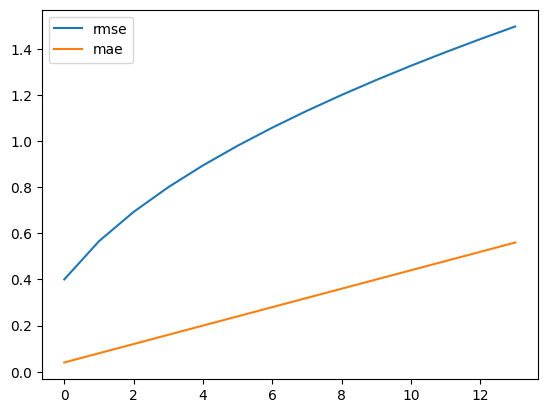

In [231]:
#  how rmse and mae changes...

fives = np.full((100, ) , 5)

preds_list = []
for i in range(1, 15):
    preds = np.full((100, ) , 5)
    preds[:i] = 1
    preds_list.append(preds)

rmse_scores = [rmse(fives, preds) for preds in preds_list]
mae_scores = [mae(fives, preds) for preds in preds_list]

plt.plot(rmse_scores, label='rmse')
plt.plot(mae_scores, label='mae')
plt.legend()

# Sooo....

- Now I know I don't have clear validation strategy.
- I don't know what to infer from all these experiments.

# Todos :

- 